<a href="https://colab.research.google.com/github/MorgenPronk/LSTM_System_Identification/blob/main/Gas_Solution_dynamics_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gas - Liquid Dynamics
This is to model how the GoA changes with pressure and other factors. This is to test some assumptions and get a model working, so it can be used in the larger dynamic system to define the system that we want to control

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [22]:
# Constants
k_B = 1.38e-23  # Boltzmann constant in J/K
T = 298.15  # Typical temperature in Kelvin # We might want to vary this value with the thermodynamics or at least with our temperature readings
gamma = 0.0728  # Surface tension in N/m
p_initial = 3.5e6  # Initial pressure in Pa
p_final = 1e6  # Final pressure in Pa
p_sat = 3.5e6 # Saturation pressure in Pa, example for natural gas
rho_g = 0.8  # Gas density in kg/m^3
D_g = 2e-9  # Diffusion coefficient in m^2/s

In [23]:
# for Jo Calc
# Constants
k_B = 1.38e-23  # Boltzmann constant in J/K
T = 350  # Temperature in Kelvin
h = 6.626e-34  # Planck's constant in J.s
rho_L = 850  # Density of oil in kg/m^3
M = 0.016  # Molar mass of methane in kg/mol

In [24]:
J_0 = (k_B * T / h) * np.sqrt((2 * np.pi * rho_L * k_B * T) / M) # m^-3 s^-1

In [25]:
# Pressure as a function of time (linear decrease)
def p(t):
    return 2*3.5e6 + 3.5e6 * np.sin(t)

In [26]:
# Initial conditions
r0 = 1e-7  # Initial radius of bubbles in meters
C0 = 0.01  # Initial concentration of dissolved gas in kg/m^3
alpha0 = 0  # Initial gas volume fraction

In [ ]:
def calc_delta_p(p_sat, p):
  return p_sat - p

In [ ]:
# Nucleation Rate Equations
def calc_J(J_0, DeltaG_star, k_B, T):
  return J_0 * np.exp(-DeltaG_star / (k_B * T))

def calc_deltaG_star(gamma, rho_g, delta_p):
  return (16 * np.pi * gamma**3) / (3 * (rho_g * delta_p)**2)

In [27]:
# System of differential equations
def gas_model(t, y):
    r, C, alpha = y
    delta_p = calc_delta_p(p_sat,p) # diff between saturation pressure and actual
    DeltaG_star = calc_deltaG_star(gamma, rho_g, delta_p) # Nucleation
    J = calc_J(J_0, DeltaG_star, k_B, T) # Nucleation

    # Bubble growth rate
    dr_dt = D_g * (rho_g - C) / r
    # Change in concentration (Mass conservation for dissolved gas)
    dC_dt = -J * (4/3) * np.pi * r**3
    # Change in gas volume fraction (Gas Volume Fraction Evolution)
    dalpha_dt = J * (4/3) * np.pi * r**3 + alpha * 3 * dr_dt

    return [dr_dt, dC_dt, dalpha_dt]

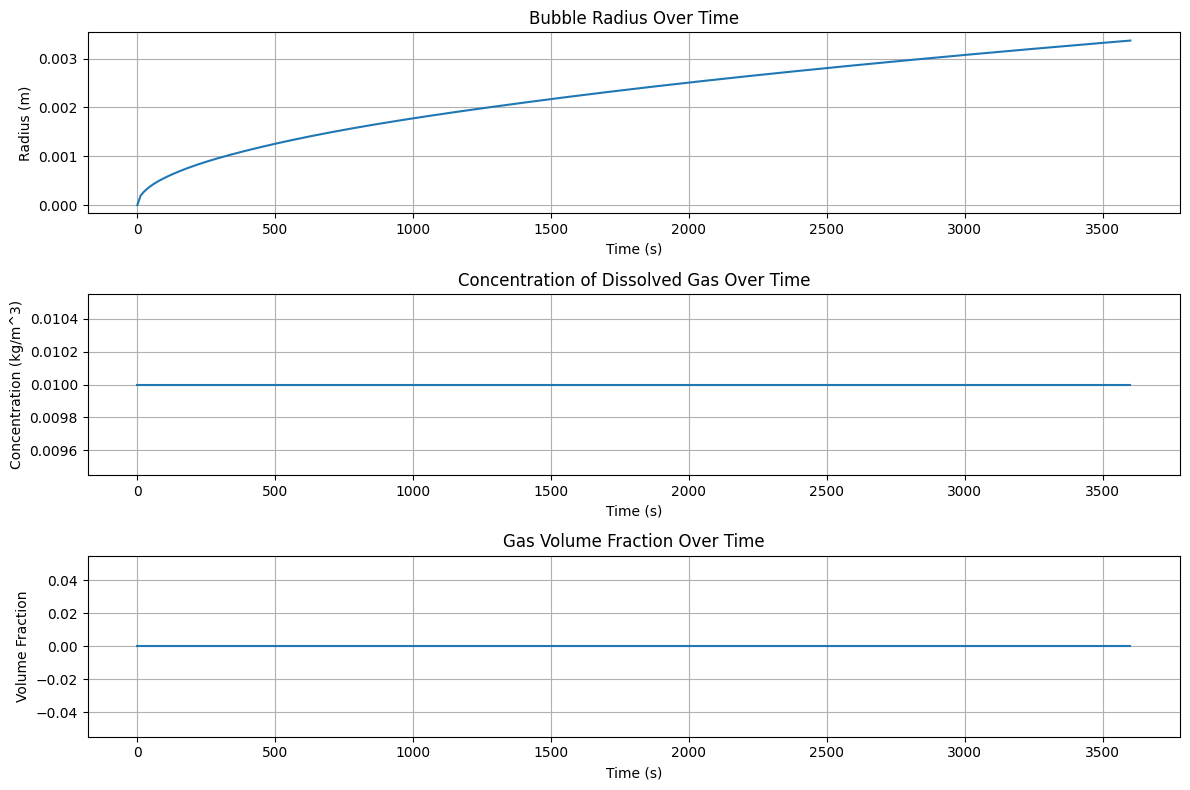

In [28]:
# Time span and initial conditions vector
t_span = (0, 3600)  # Integration time in seconds (1 hour)
y0 = [r0, C0, alpha0]

# Solving the system
sol = solve_ivp(gas_model, t_span, y0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 300))

# Nucleation rate
vec_calc_J = np.vectorize(calc_J)
J = vec_calc_J()

# Plotting results
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(sol.t, sol.y[0], label='Bubble radius (m)')
plt.title('Bubble Radius Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Radius (m)')
plt.grid(True)

plt.subplot(312)
plt.plot(sol.t, sol.y[1], label='Concentration of dissolved gas (kg/m^3)')
plt.title('Concentration of Dissolved Gas Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (kg/m^3)')
plt.grid(True)

plt.subplot(313)
plt.plot(sol.t, sol.y[2], label='Gas volume fraction')
plt.title('Gas Volume Fraction Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Volume Fraction')
plt.grid(True)

plt.tight_layout()
plt.show()